# Úkol č. 1 - předzpracování dat a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz](https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzašším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s klasifikační úlohou s příznaky různých typů.
* Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem se vypořádejte s chybějícími hodnotami. _Pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **survived**. Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

  * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,survived
1000,0
1001,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.

# Řešení

## Zpracování dat

> ##### Naimportuju potřebné baličky

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics

> ##### Načteme dataset

In [2]:
df = pd.read_csv("data.csv")

> ##### Podíváme se jak dataset vypadá

In [3]:
df.head()

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,3,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q,NaN
4,4,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"


> ##### Podíváme se na rovnováhu vysvětlované proměnné

In [4]:
df.survived.value_counts(normalize=True)

survived
0    0.602
1    0.398
Name: proportion, dtype: float64

> ##### 👆Vidíme, že data nemají velkou disbalanci.

> ##### Podíváme se na informace o datasetu

In [5]:
df.shape

(1000, 13)

In [6]:
df.dtypes

ID             int64
survived       int64
pclass         int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
home.dest     object
dtype: object

In [7]:
df.nunique()

ID           1000
survived        2
pclass          3
name          999
sex             2
age            95
sibsp           7
parch           8
ticket        746
fare          254
cabin         157
embarked        3
home.dest     313
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        802 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      233 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  566 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


> ##### Smažu sloupce které podle mě nemají vliv na predikci

In [9]:
 df.drop(columns=["ID", "name", "ticket", "cabin", "home.dest"], inplace=True)

> ##### Zkontrolujeme všechny přiznaky na prazdné hodnoty

In [10]:
words = ["Unknown", "N/A", "None", "-", "?", ""] # co tam asi muze byt
word_stats = {}

for col in df.columns:
    count = 0
    for word in words:
        count += (df[col] == word).sum()
    word_stats[col] = count

for col, count in word_stats.items():
    print(f"Přiznak {col}: {count} prázdných hodnot")

Přiznak survived: 0 prázdných hodnot
Přiznak pclass: 0 prázdných hodnot
Přiznak sex: 0 prázdných hodnot
Přiznak age: 0 prázdných hodnot
Přiznak sibsp: 0 prázdných hodnot
Přiznak parch: 0 prázdných hodnot
Přiznak fare: 0 prázdných hodnot
Přiznak embarked: 0 prázdných hodnot


> ##### Podíváme se jaké jsou nečíselné příznaky

In [11]:
string_columns = df.select_dtypes(['object']).columns
print(string_columns)
df[string_columns].nunique()

Index(['sex', 'embarked'], dtype='object')


sex         2
embarked    3
dtype: int64

> ##### Tyto příznaky jsou kategorické, jejich typ změním na category a nahradím je číselnými kódy

In [12]:
# df[string_columns] = df[string_columns].astype('category').apply(lambda x: x.cat.codes)

label_encoders = {}

for column in string_columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

> ##### 👆 Zde používám LabelEncoder, abych mohl při evaluaci použít stejné kódování proměnných

> ##### Rozdělím data

In [13]:
Xdata = df.drop("survived", axis = 1)
ydata = df.survived

In [14]:
random_seed = 111
# train = 60% val = 20% test = 20%
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.4, random_state=random_seed) 
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=random_seed) 

> ##### V přiznaku ***age*** všech datových skupin nahradím "Nan" mediánem z trénovacích dat, aby se zabránilo úniku testovacích dat do trénovacích

In [15]:
age_median = Xtrain["age"].median()
Xtrain["age"] = Xtrain["age"].fillna(age_median)
Xval["age"] = Xval["age"].fillna(age_median)
Xtest["age"] = Xtest["age"].fillna(age_median)

> ##### Obdobně v přiznaku ***fare***

In [16]:
fare_median = Xtrain["fare"].median()
Xtrain["fare"] = Xtrain["fare"].fillna(fare_median)
Xval["fare"] = Xval["fare"].fillna(fare_median)
Xtest["fare"] = Xtest["fare"].fillna(fare_median)

> ##### Vyměmím zbylé nan na -1

In [17]:
Xtrain = Xtrain.replace(np.nan, -1)
Xval = Xval.replace(np.nan, -1)
Xtest = Xtest.replace(np.nan, -1)

## Decision tree

> ##### Podíváme se na hyperparametry stromu

In [18]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

> ##### Vyberu možnosti hyperparametrů, které budu ladit

In [19]:
depths = range(1,31)
param_grid = {
    'max_depth': depths,
    'criterion': ['entropy', 'gini']}

param_comb = ParameterGrid(param_grid)

> ##### Pro každou kombinaci hyperparametrů zapíšu přesnost modelu do pole

In [20]:
# pole delam abych mohl vykreslit graf
train_accuracy = [] # pole pro presnosti na trenovaci mnozine
val_accuracy = [] # pole pro presnosti na validacni mnozine
train_accuracy_gini = [] # pole pro presnosti na trenovaci mnozine s indexem gini
val_accuracy_gini = [] # pole pro presnosti na validacni mnozine s indexem gini
best_params = None
best_score = 0

for params in param_comb:
    model = DecisionTreeClassifier(**params)
    model.fit(Xtrain, ytrain)
    if params['criterion'] == "entropy":
        train_accuracy.append(metrics.accuracy_score(ytrain, model.predict(Xtrain)))
        score = metrics.accuracy_score(yval, model.predict(Xval))
        val_accuracy.append(score)
    else:
        train_accuracy_gini.append(metrics.accuracy_score(ytrain, model.predict(Xtrain)))
        score = metrics.accuracy_score(yval, model.predict(Xval))
        val_accuracy_gini.append(score)
    if score > best_score:
        best_score = score
        best_params = params

> ##### Vykreslime graf pro srovnavani presnosti na obou mnozinach

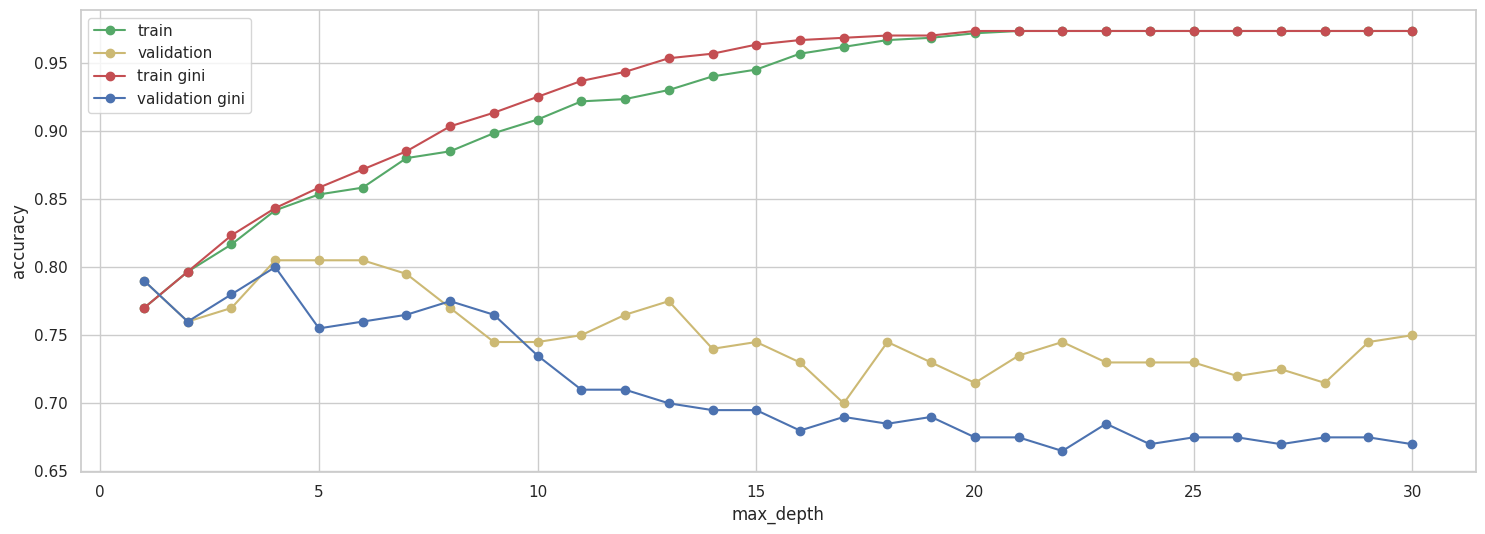

In [21]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(depths, train_accuracy, 'og-', label='train')
ax.plot(depths, val_accuracy, 'oy-', label="validation")
ax.plot(depths, train_accuracy_gini, 'or-', label='train gini')
ax.plot(depths, val_accuracy_gini, 'ob-', label="validation gini")
ax.set_xlabel('max_depth')
ax.set_ylabel('accuracy')
ax.legend();

> ##### 👆Zde je vidět, že v určitém okamžiku se model začne přeučovat a přesnost na trénovacích datech roste, ale na validačních datech již klesá.

> ##### Podíváme se na nejlepší hyperparametry

In [22]:
best_params

{'criterion': 'entropy', 'max_depth': 4}

> ##### Nafitujeme model s nejlepšími hyperparametry

In [23]:
tree_model = DecisionTreeClassifier(**best_params)
tree_model.fit(Xtrain, ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

> ##### Podíváme se na přesnost nejlepšího modelu

In [24]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, tree_model.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, tree_model.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, tree_model.predict(Xtest))))

accuracy score (train): 0.841667
accuracy score (validation): 0.805000
accuracy score (test): 0.735000


> ##### Vypočítám F1 skóre pro strom

In [25]:
print(f'F1 score (test): {metrics.f1_score(ytest, tree_model.predict(Xtest)):.4f}')

F1 score (test): 0.6074


> ##### Nakreslím ROC křivku a určím AUC pro strom

In [26]:
y_pred_proba = tree_model.predict_proba(Xtest) # spocitame pravdepodobnosti pro kazdy radek
p1_hat = y_pred_proba[:,1] # vezmeme pravdepodobnost pro kladnou tridu (pravdepodobnost, ze mame 1)

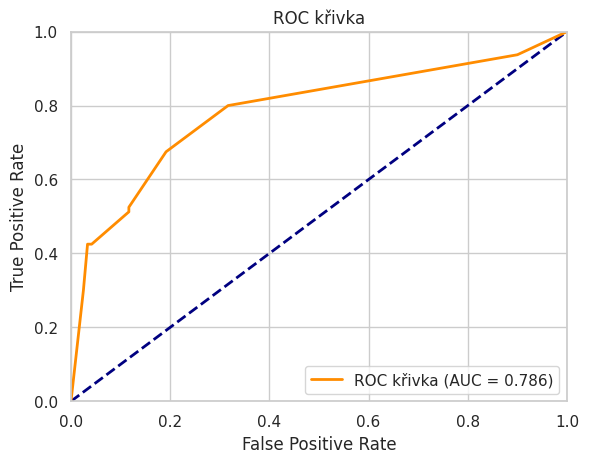

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(ytest, p1_hat) # spocitame False Positive Rate, True Positive Rate a thresholdy
 
AUC = metrics.auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {AUC:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka")
plt.legend(loc="lower right");

> ##### Hodnota AUC = 0,786 je dobrá ale není perfektní, což naznačuje, že v modelu ještě je prostor pro zlepšení

### Argumenty pro a proti Decision Tree  

#### Pro👍: 
- Zpracování kategorických dat - Dobře zpracovávají kategorické proměnné, což je užitečné.
- Detekce významných proměnných - Automaticky vybírají důležité proměnné, což je pro analýzu dat výhodné.
  
#### Proti👎:
- Sklon k přeučení - Mohou být náchylné k přeučení, pokud jsou data příliš komplikovaná.

## KNN

> ##### Podíváme se na hyperparametry KNN

In [28]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

> ##### Vyberu možnosti hyperparametrů, které budu ladit

In [29]:
param_grid = {
    'n_neighbors': range(3,21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']}

param_comb = ParameterGrid(param_grid)

> ##### Pro normalizaci dat použíju Min-max scaler

In [30]:
# Min-max scaler nafitujeme na trenovacich datech
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)

# Pak stejnou transformaci aplikuju i na validacni a testovaci data
Xval_scaled = scaler.transform(Xval)
Xtest_scaled = scaler.transform(Xtest)

> ##### Vyberu nejlepší hyperparametry pro model

In [31]:
best_params = None
best_score = 0

for params in param_comb:
    model = KNeighborsClassifier(**params)
    model.fit(Xtrain_scaled, ytrain)
    score = metrics.accuracy_score(yval, model.predict(Xval_scaled))
    if score > best_score:
        best_score = score
        best_params = params

In [32]:
best_params

{'algorithm': 'ball_tree',
 'metric': 'euclidean',
 'n_neighbors': 15,
 'weights': 'uniform'}

> ##### Nafitujeme model s nejlepšími hyperparametry

In [33]:
knn_model = KNeighborsClassifier(**best_params)
knn_model.fit(Xtrain_scaled, ytrain)

KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=15)

> ##### Podíváme se na přesnost nejlepšího modelu

In [34]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, knn_model.predict(Xtrain_scaled))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, knn_model.predict(Xval_scaled))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, knn_model.predict(Xtest_scaled))))

accuracy score (train): 0.811667
accuracy score (validation): 0.835000
accuracy score (test): 0.745000


> ##### Vypočítám F1 skóre pro KNN

In [35]:
print(f'F1 score (test): {metrics.f1_score(ytest, knn_model.predict(Xtest_scaled)):.4f}')

F1 score (test): 0.6331


> ##### Nakreslím ROC křivku a určím AUC pro KNN

In [36]:
y_pred_proba = knn_model.predict_proba(Xtest_scaled) # spocitame pravdepodobnosti pro kazdy radek
p1_hat = y_pred_proba[:,1] # vezmeme pravdepodobnost pro kladnou tridu (pravdepodobnost, ze mame 1)

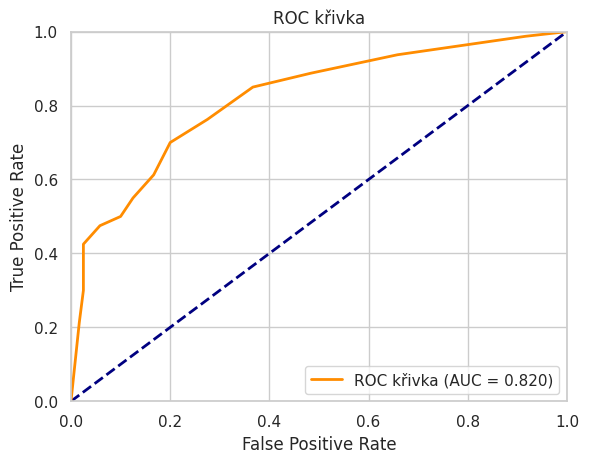

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(ytest, p1_hat) # spocitame False Positive Rate, True Positive Rate a thresholdy

AUC = metrics.auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {AUC:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka")
plt.legend(loc="lower right");

> ##### Hodnota AUC = 0,82 je poměrně dobrá, což ukazuje na dobrý model 😃

### Argumenty pro a proti KNN 

#### Pro👍: 
- Snadná implementace a porozumění: Metoda KNN je snadno pochopitelná a implementovatelná.
  
#### Proti👎:
- Vysoké nároky na výpočetní výkon a paměť: v mém případě byla pro KNN potřeba větší síť hyperparametrů).

## Finalní model

> Podle výsledků, které jsem získal po natrénování obou modelů, jsem se rozhodl zvolit finální model pomocí AUC. Vzhledem k tomu, že data ve vysvětlované proměnné nejsou vysoce disbalancovaná, nebudu používat F1 skore. Jako finalní model jsem tedy zvolil KNN. Přesnost modelu lze odvodit z přesnosti na testovacích datech, která je u KNN přibližně 0,75.

## Evaluace

> ##### Načteme dataset evaluation

In [38]:
df_eval = pd.read_csv("evaluation.csv")

> ##### Prázdné hodnoty věku a ceny vyplním **stejnými** hodnotami jako v souboru dat pro trénování

In [39]:
df_eval["age"] = df_eval["age"].fillna(age_median)

In [40]:
df_eval["fare"] = df_eval["fare"].fillna(fare_median)

> ##### Odstraním stejné zbytečné příznaky jako v trénovacím datasetu

In [41]:
id = df_eval["ID"]
df_eval.drop(columns=["ID", "name", "ticket", "cabin", "home.dest"], inplace=True)

> ##### Kategorické příznaky převedu do **stejného** kódování jako v datasetu pro trénování.

In [42]:
string_columns = df_eval.select_dtypes(['object']).columns
df_eval[string_columns].nunique()

sex         2
embarked    3
dtype: int64

In [43]:
for column in string_columns:
    df_eval[column] = label_encoders[column].transform(df_eval[column])

> ##### Vyměmím zbylé nan na -1

In [44]:
df_eval = df_eval.replace(np.nan, -1)

> ##### Pro normalizaci dat použíju **stejný** Min-max scaler

In [45]:
df_eval_scaled = scaler.transform(df_eval)

> ##### Udělám predikci pro dataset evaluation a výsledky uložím do souboru results.csv

In [46]:
predicted_survived = knn_model.predict(df_eval_scaled)

df_result = pd.DataFrame({
    'ID': id,
    'survived': predicted_survived
})

df_result.to_csv('results.csv', index=False)

> ##### Podíváme se na výsledky predikce

In [47]:
df_result["survived"].value_counts()

survived
0    233
1     76
Name: count, dtype: int64

### Konec :)